# Orbital-Parameters
the goal of this notebook is to investigate which orbital parameters are most important for the stream orbit tracing. We will use the following parameters:

* $a$ - semi-major axis
* $e$ - eccentricity
* $i$ - inclination
* $\Omega$ - longitude of the ascending node
* $\omega$ - argument of pericenter
* $M$ - mean anomaly

Just kidding, which parameters are important? We will use the following parameters:

* $a$ - semi-major axis
* $e$ - eccentricity
* $\omega$ - The angular velocity
* $\dot{\omega}$ - the rate of change of the angular velocity
* $L_z$ the angular momentum

I should read all of chapter three of Binney and Tremaine

Step one is to look at $\omega$ and $\dot{\omega}$



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import sys
sys.path.append("/home/sferrone/GC-tidal-loss/experiments/functions/")
import inputMW
import inputGC
sys.path.append("../src/")
import orbitCoords as OC
import trace_orbit as TO 
from scipy.interpolate import CubicSpline

In [2]:
def getOmega(GCnames):
    """
    load in the orbital parameters of each GC's COM
    RETURNS:
        omega: the angular velocity of the GC's COM
        omegaNorm: the mangitude of the angular velocity vector
    """
    omegas,omegaNorm=[],[]
    for k in range(len(GCnames)):
        COM=OC.getCOM(GCnames[k])
        rvec=[COM.x.value,COM.y.value,COM.z.value]
        vvec=[COM.v_x.value,COM.v_y.value,COM.v_z.value]
        omega=np.cross(rvec,vvec)/np.linalg.norm(rvec)**2
        omegas.append(omega)
        omegaNorm.append(np.linalg.norm(omega))
    return omegas,omegaNorm

In [24]:
def ColorBarSampling(GCnames,CMAP="hsv"):
    """
    plot the yprime values for each GC
    """
    cmap = plt.cm.get_cmap(CMAP)
    GCnames=np.array(GCnames)
    mycolors=[]
    sampling=np.linspace(0,1,len(GCnames))
    for i in range(len(GCnames)):
        mycolors.append(cmap(sampling[i]))
    return mycolors

def RandomMirrorLabelling(GCnames):
    """
    Determine if the label of the GC will be applied to the top or bottom of the stream
    """
    topBottom=np.random.rand(len(GCnames))
    condB=topBottom<0.5
    condT=topBottom>0.5
    topBottom[condB]=1
    topBottom[condT]=0
    return topBottom

def yprimePlot(x,yprimes,GCnames,scatterColors,topBottom,xlabel=r"$\omega$ (km s$^{-1}$ kpc$^{-1}$)",ylabel=r"$\bar{\delta y'}$ (kpc)"):
    """
    plot the yprime values for each GC
    """
    fig,ax=plt.subplots(figsize=(8,6))
    ax.scatter(x,yprimes['trailing'],c=scatterColors)
    ax.scatter(x,yprimes['leading'],c=scatterColors)
    ax.grid(True,alpha=0.1)
    for k in range(len(GCnames)):
        if topBottom[k]:
            ax.text(x[k],yprimes['leading'][k],GCnames[k])
        else:
            ax.text(x[k],yprimes['trailing'][k],GCnames[k])
    ax.set_ylabel(ylabel,size=15);
    ax.set_xlabel(xlabel,size=15);
    return fig,ax 

In [4]:
k=0
# grab the orbits
GCnames,version,model=np.loadtxt("../little-data/clean_stream.txt",delimiter=',',dtype=str,unpack=True)
f=open("../little-data/config.json")
C = json.load(f)
backwardpath,forwardpath=TO.orbitpath(C)
streampath=TO.get_streampath(version=version[k],model=model[k])
yprimes=pd.read_csv("../little-data/gc_yprimes.csv",sep=",")
plt.style.use('dark_background')

EDR3 PII


## $\omega$

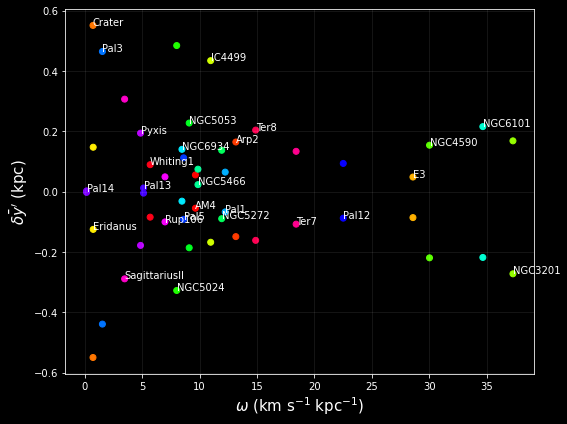

In [69]:
omegas,omegaNorm=getOmega(GCnames)
scatterColors=ColorBarSampling(GCnames)
topBottom=RandomMirrorLabelling(GCnames)
outdir="../../../plots/EDR3/PII/ensemble/"
reportdir="../../report/2023-04-05/ensemble/"
outname="yprime_vs_omega.png"
fig,ax=yprimePlot(omegaNorm,yprimes,GCnames,scatterColors,topBottom)
fig.tight_layout()
fig.savefig(outdir+outname,dpi=300)
fig.savefig(reportdir+outname,dpi=300)

## $\dot{\omega}$

In [7]:
# Get the cubic spline of omega to obtain omega dot
def getOmegaDot(t,W):
    """
    get the derivative of omega
    """
    pos=W[:,:3]
    vel=10*W[:,3:] # remember the integration units are 10 km/s
    RxV=np.cross(pos,vel,axis=1)
    R2 = np.linalg.norm(pos,axis=1)**2
    omega = np.array([RxV[i]/R2[i] for i in range(len(R2))])
    omegamag=np.linalg.norm(omega,axis=1)
    OmegaDotFunc=CubicSpline(t,omegamag,1)
    omegaDot=OmegaDotFunc(t,1)
    return omega,omegamag,omegaDot
    


In [8]:
# get the omega and oemga dot for all GCnames
omegas,omegaNorms=[],[]
omegaDots=[]
Ws =[]
for k in range(len(GCnames)):
    print(GCnames[k])
    t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
    omega,omegamag,omegaDotMag=getOmegaDot(t,W)
    omegas.append(omega)
    omegaNorms.append(np.linalg.norm(omegamag))
    omegaDots.append(omegaDotMag)
    Ws.append(W)

AM4
Arp2
Crater
E3
Eridanus
IC4499
NGC3201
NGC4590
NGC5024
NGC5053
NGC5272
NGC5466
NGC6101
NGC6934
Pal1
Pal3
Pal5
Pal12
Pal13
Pal14
Pyxis
Rup106
SagittariusII
Ter7
Ter8
Whiting1


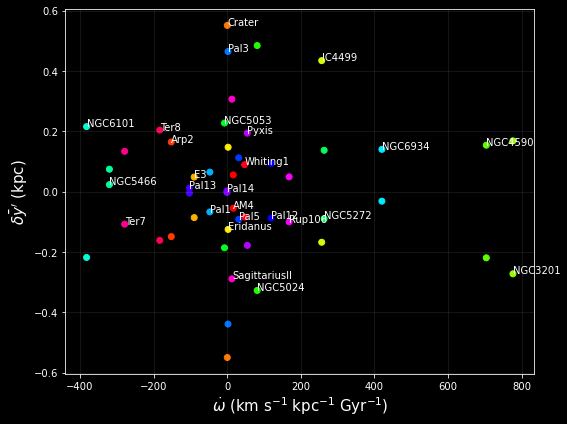

In [70]:
# get omega dot today 
index = np.where(t==0)[0][0]
omegaDotToday=np.array([omegaDots[k][index] for k in range(len(GCnames))])
# now plot
fig,ax=yprimePlot(omegaDotToday,yprimes,GCnames,scatterColors,topBottom,xlabel=r"$\dot{\omega}$ (km s$^{-1}$ kpc$^{-1}$ Gyr$^{-1}$)",ylabel=r"$\bar{\delta y'}$ (kpc)")
outdir="../../../plots/EDR3/PII/ensemble/"
outname="yprime_vs_omegaDot.png"
fig.tight_layout()
fig.savefig(outdir+outname,dpi=300)
fig.savefig(reportdir+outname,dpi=300)

### The orbital psuedo keplerian orbital parameters 

In [63]:
# get semi-major axis for each 
major=[]
minor=[]
eccen=[]
inclin=[]
for k in range(len(GCnames)):
    r = np.linalg.norm(Ws[k][:,:3],axis=1)
    R = np.linalg.norm(Ws[k][:,:2],axis=1)
    zmax=np.max(Ws[k][:,2])
    major.append(np.max(r))
    minor.append(np.min(r))
    eccen.append((np.max(r)-np.min(r))/(np.max(r)+np.min(r)))
    inclin.append((180/np.pi)*np.arctan2(zmax,R.max()))

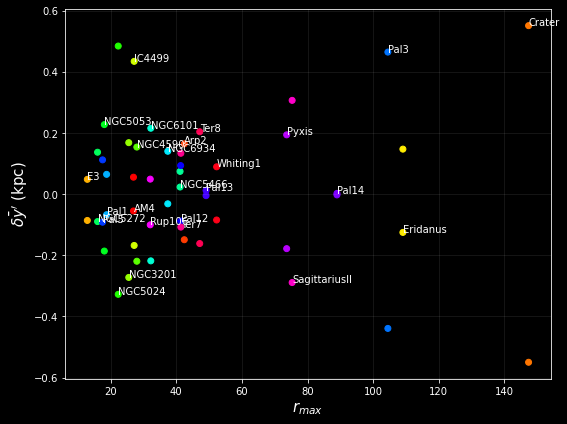

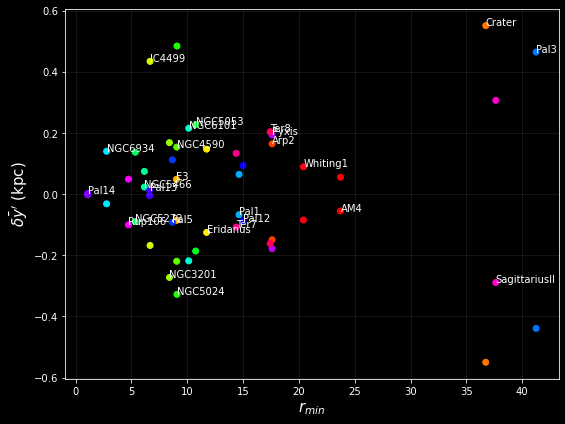

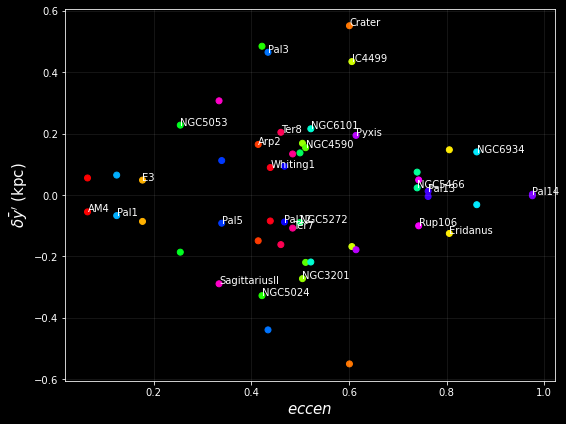

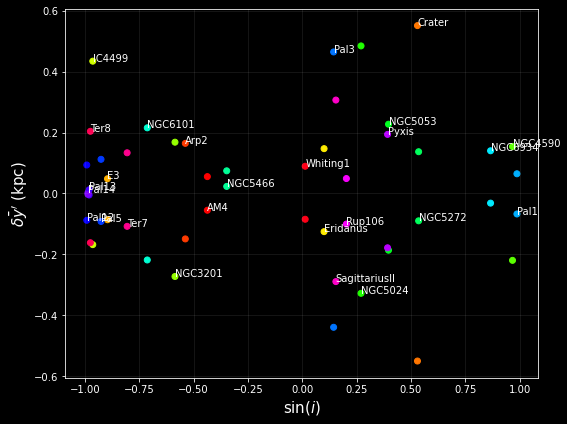

In [71]:
fig,ax=yprimePlot(major,yprimes,GCnames,scatterColors,topBottom,xlabel=r"$r_{max}$",ylabel=r"$\bar{\delta y'}$ (kpc)")
outname="yprime_vs_semimajor.png"
fig.tight_layout()
fig.savefig(outdir+outname,dpi=300)
fig.savefig(reportdir+outname,dpi=300)
fig,ax=yprimePlot(minor,yprimes,GCnames,scatterColors,topBottom,xlabel=r"$r_{min}$",ylabel=r"$\bar{\delta y'}$ (kpc)")
outname="yprime_vs_semiminor.png"
fig.tight_layout()
fig.savefig(outdir+outname,dpi=300)
fig.savefig(reportdir+outname,dpi=300)
fig,ax=yprimePlot(eccen,yprimes,GCnames,scatterColors,topBottom,xlabel=r"$eccen$",ylabel=r"$\bar{\delta y'}$ (kpc)")
outname="yprime_vs_eccentricity.png"
fig.tight_layout()
fig.savefig(outdir+outname,dpi=300)
fig.savefig(reportdir+outname,dpi=300)
fig,ax=yprimePlot(np.sin(inclin),yprimes,GCnames,scatterColors,topBottom,xlabel=r"$\sin(i)$",ylabel=r"$\bar{\delta y'}$ (kpc)")
outname="yprime_vs_sin_inclination.png"
fig.tight_layout()
fig.savefig(outdir+outname,dpi=300)
fig.savefig(reportdir+outname,dpi=300)

## total orbital energy